## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


## Clone baseline and create emission bound scenario

In [12]:
# this is to import scenario from data base and clone to local
base = message_ix.Scenario(mp, model='GENIE_sandbox', scenario="baselineYWP")
scen = base.clone(
    "GENIE_sandbox",
    "daccs1000_paper_repro",
    "adding daccs and mission bound to baseline scenario",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


In [13]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/tech_data.yaml'
add_tech(scen,filepath=filepath)

In [14]:
# removing some parameters
pars2remove = ['emission_factor','capacity_factor','var_cost','output']
for par in pars2remove:
    df = scen.par(par,{'technology':'dacco2_tr_dis'})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['capacity_factor','fix_cost','input']
techs = ['dac_2', 'dac_1', 'dac_3', 'dac_4', 'dac_5']
for par in pars2remove:
    df = scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    scen.remove_par(par, df)

#### Add emission bound

In [15]:
# add emission bound
scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")


## Run the model

In [16]:
scen.commit(comment="DACs scenario with emission bound")
scen.set_as_default()

In [17]:
scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
scen.var("OBJ")["lvl"]

2221843.5

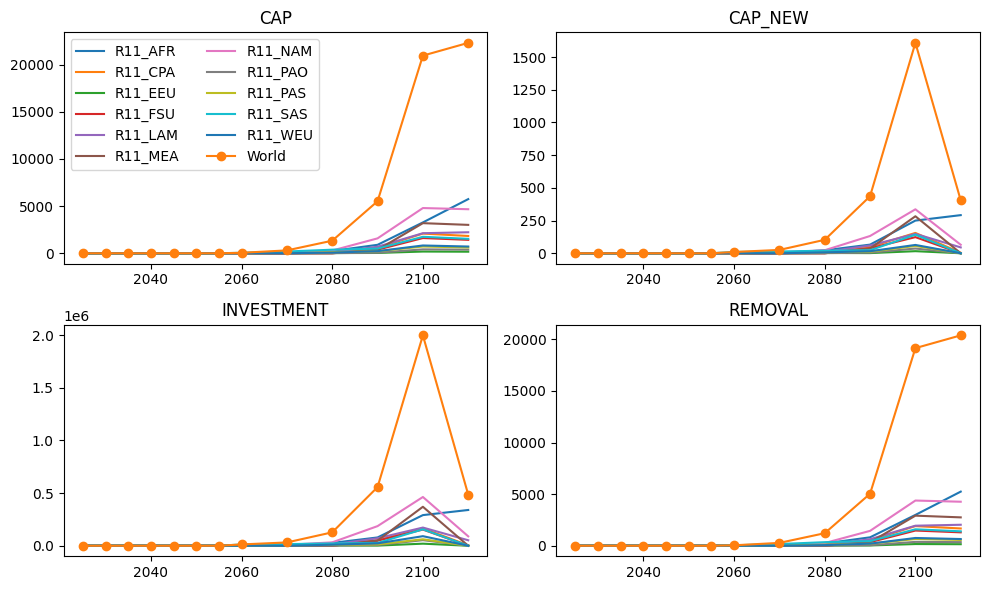

In [18]:
# Get Report
scenario = message_ix.Scenario(mp, model="GENIE_sandbox", scenario="daccs1000_paper_repro")
scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']

scenario_report = get_report(scenario,scenariotec)


## Close connection

In [19]:
mp.close_db()